# SAR Playground 

This notebook contains training and inference code for mmdetection 3x on SARscope Dataset. This can be used as a baseline for using mmdetection.

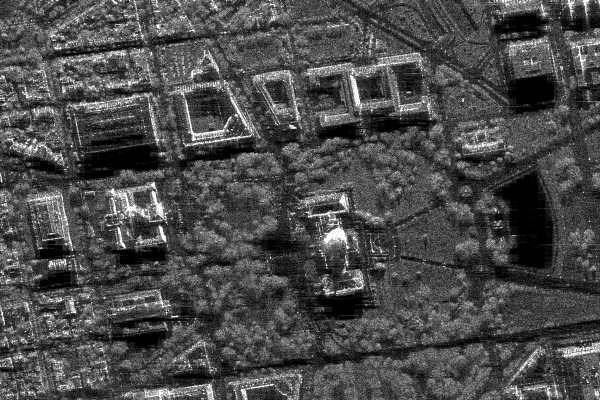


Unlike regular **Google Colab** enviroonment , linux kernal has not been very friendly to MMDetection pakage from my experience, there was a lot of issues from installation to configuring runtime and finally training models


Here in this notebook we have Adaptive Training Sample Selection, or ATSS model trained in SARscope data. 


Special thanks to -- https://www.kaggle.com/datasets/ammarnassanalhajali/mmdetectron-31-wheel/ Who puplished fully built wheels for making **MMDetection 3.1** working on this kaggle notebook. Below is the installation code for building wheels nessesary for MMDetection.
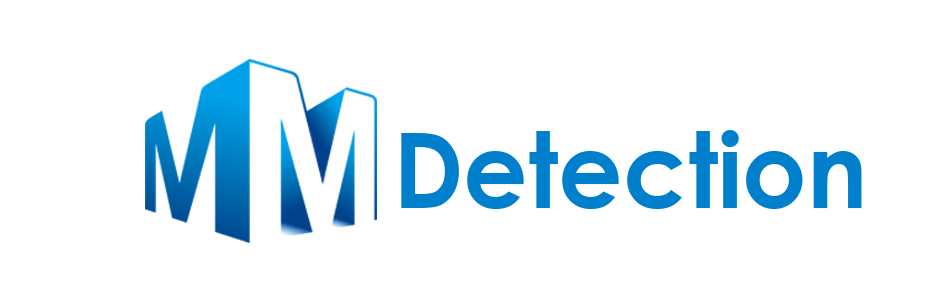

In [1]:
from IPython.display import clear_output

!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/torch-1.12.1+cu116-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/torchvision-0.13.1+cu116-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/mmcv-2.0.1-cp310-cp310-manylinux1_x86_64.whl 
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/openmim-0.3.9-py2.py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/mmengine-0.7.4-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/addict-2.4.0-py3-none-any.whl
!pip install yapf==0.40.1

clear_output()

## Importing the required pakages

In [2]:
from tqdm.notebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from glob import glob
import matplotlib.pyplot as plt

## Git cloning and installing MMDetection 3.1

Notice here we're cloning a specific tag/branch of MMDetection that house the 3.1 version of the library. Any other version would cause dependency issues while working.

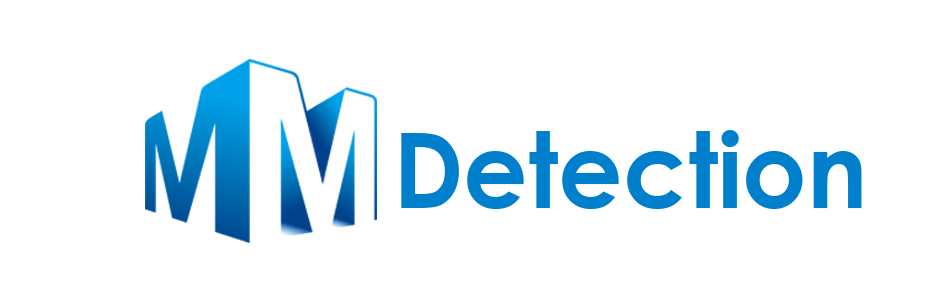
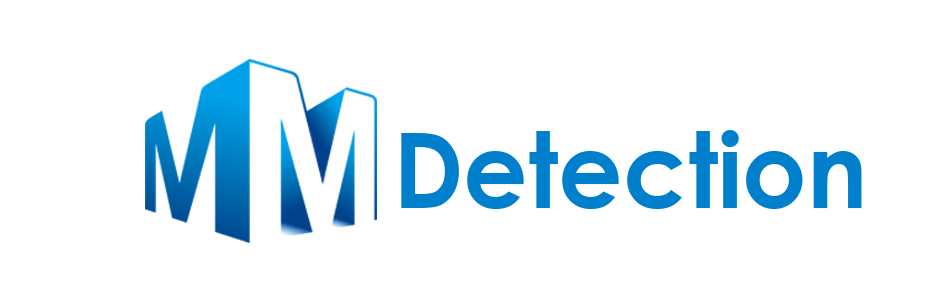

In [3]:
!git clone -bv3.1.0 https://github.com/open-mmlab/mmdetection.git
%cd /kaggle/working/mmdetection
!pip install -v -e .

clear_output()

In [4]:
import torch, torchvision,mmdet
print("PyTorch version= ",torch.__version__,torch.cuda.is_available())
print("mmdet version= ",mmdet.__version__)

from mmcv.ops import get_compiling_cuda_version
print("THE CUDA version ", get_compiling_cuda_version())

PyTorch version=  1.12.1+cu116 True
mmdet version=  3.1.0
THE CUDA version  11.6


## Downloading the model weights 

Adaptive Training Sample Selection, or ATSS model weights are downloaded and moved to chekpoint directory.

In [5]:
!wget -O atss_r101_fpn_1x.pth "https://download.openmmlab.com/mmdetection/v2.0/atss/atss_r101_fpn_1x_coco/atss_r101_fpn_1x_20200825-dfcadd6f.pth"

--2023-12-16 03:19:19--  https://download.openmmlab.com/mmdetection/v2.0/atss/atss_r101_fpn_1x_coco/atss_r101_fpn_1x_20200825-dfcadd6f.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.210, 8.48.85.208, 8.48.85.209, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205688600 (196M) [application/octet-stream]
Saving to: ‘atss_r101_fpn_1x.pth’

atss_r101_fpn_1x.pt 100%[===================>] 196.16M  17.4MB/s    in 11s     

2023-12-16 03:19:31 (17.9 MB/s) - ‘atss_r101_fpn_1x.pth’ saved [205688600/205688600]



## Writing the config files 

- MMDetection uses a modular design, all modules with different functions can be configured through the config.

- In MMDetection’s config, we use `model` to set up detection algorithm components. In addition to neural network components such as `backbone, neck,` etc, it also requires `data_preprocessor, train_cfg,` and `test_cfg.` `data_preprocessor` is responsible for processing a batch of data output by dataloader. `train_cfg`, and `test_cfg` in the model config are for training and testing hyperparameters of the components.

- The configs can be loaded and changed in a dictionary like key-value style assignment as shown below. Or alternatively we could inherit the script and rewrite the code.

For more on configs refer MMEngine docs on configs

https://mmengine.readthedocs.io/en/latest/advanced_tutorials/config.html#read-the-configuration-file

In [6]:
from mmengine.config import Config
base="atss_r101_fpn_1x_coco"
cfg = Config.fromfile(f'/kaggle/working/mmdetection/configs/atss/{base}.py')
#----------------------------------------------------
width=640
height=640

max_epochs=2

batch_size=2
num_classes=1

dataset_type = 'CocoDataset' 
classes = ('ship', ) 
data_root = '/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope'
#-----------------------------------------------------
cfg.model.bbox_head.num_classes = num_classes
#-----------------------------------------------------
cfg.train_pipeline[2]['scale']=(width,height)
cfg.test_pipeline [1]['scale']=(width,height)

max_epochs is set to just 2 as ths notebook provides a template code for working with MMDetection and training on custom data, you can adjust the parameters as you wish

In [7]:
#-----------------------------------------------------
cfg.train_dataloader.dataset.type=dataset_type
cfg.train_dataloader.dataset.metainfo=dict(classes=classes)
cfg.train_dataloader.dataset.data_root=data_root
cfg.train_dataloader.dataset.ann_file='/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/train/_annotations.coco.json'
cfg.train_dataloader.dataset.data_prefix=dict(img='train/')
cfg.train_dataloader.batch_size=batch_size
cfg.train_dataloader.dataset.pipeline[2]['scale']=(width,height)
#-----------------------------------------------------
cfg.val_dataloader.dataset.type=dataset_type
cfg.val_dataloader.dataset.metainfo=dict(classes=classes)
cfg.val_dataloader.dataset.data_root=data_root
cfg.val_dataloader.dataset.ann_file='/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid/_annotations.coco.json'
cfg.val_dataloader.dataset.data_prefix=dict(img='valid/')
cfg.val_dataloader.dataset.pipeline[1]['scale']=(width,height)
#-----------------------------------------------------
cfg.test_dataloader.dataset.type=dataset_type
cfg.test_dataloader.dataset.metainfo=dict(classes=classes)
cfg.test_dataloader.dataset.data_root=data_root
cfg.test_dataloader.dataset.ann_file='/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/_annotations.coco.json'

cfg.test_dataloader.dataset.data_prefix=dict(img='test/')
cfg.test_dataloader.dataset.pipeline[1]['scale']=(width,height)
#------------------------------------------------------

In [8]:
#------------------------------------------------------
cfg.val_evaluator.type='CocoMetric'
cfg.val_evaluator.ann_file='/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid/_annotations.coco.json'
# cfg.val_evaluator.metric=['segm']

cfg.test_evaluator.type='CocoMetric'
cfg.test_evaluator.ann_file='/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/_annotations.coco.json'
# cfg.test_evaluator.metric=['segm']
#------------------------------------------------------
cfg.train_cfg.max_epochs=max_epochs
cfg.optim_wrapper.type='OptimWrapper'
cfg.optim_wrapper.optimizer=dict(type='AdamW',lr=0.001,weight_decay=0.05,eps=1e-8,betas=(0.9, 0.999))
cfg.default_hooks = dict(logger=dict(type='LoggerHook', interval=200),
                         checkpoint=dict(type='CheckpointHook', interval=1, save_best='auto'))

#------------------------------------------------------
!mkdir -p configs/HuBMAP
config=f'configs/HuBMAP/custom_config_{base}_{width}_{height}.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

## Training the model 

The `config` path is pass on to train.py as an argument , which then starts training of the model for 2 epochs , resutls are printed at the end of each epoch.

In [9]:
!python /kaggle/working/mmdetection/tools/train.py {config}

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
12/16 03:19:41 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
    CUDA available: True
    numpy_random_seed: 1087695295
    GPU 0,1: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf